In [57]:
# Imports
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import altair as alt
from vega_datasets import data

In [58]:
# Select data
datasets = ["../OECD/Cleaned/HEALTH_MERGED_Threshold_80_n3.csv", "../WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRTNE.csv"]
OECD = False  # False for WB data
if OECD:
    df = pd.read_csv(datasets[0])
    mm_ind = "MATIMATM"
else:
    df = pd.read_csv(datasets[1])
    mm_ind = "SH.STA.MMRT.NE"

## Data Preparation

In [59]:
# Reduce to only gender indicators

if not OECD:
    gender_ind = pd.read_csv('../WorldBankDatasets/Gender_WorldBankData.csv').columns
    df = df.drop(columns=[col for col in df if col not in gender_ind])

df.head()

,Country,Year,SE.ENR.PRIM.FM.ZS,SE.ENR.PRSC.FM.ZS,SE.ENR.SECO.FM.ZS,SE.ENR.TERT.FM.ZS,SE.PRE.ENRR.FE,SE.PRE.ENRR.MA,SE.PRM.CMPT.FE.ZS,SE.PRM.CMPT.MA.ZS,...,SP.POP.AG01.FE.IN,SP.POP.AG01.MA.IN,SP.POP.AG02.FE.IN,SP.POP.AG02.MA.IN,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN
0,AUS,1997,0.416833,0.590957,0.561862,0.602762,0.716846,0.701958,0.618923,0.596648,...,0.061052,0.061697,0.061782,0.062388,0.061998,0.062655,0.061625,0.062167,0.062101,0.062484
1,AUS,2000,0.485202,0.529175,0.508456,0.689233,0.716846,0.701958,0.516857,0.512608,...,0.060289,0.060719,0.060532,0.061015,0.061063,0.061656,0.061521,0.062078,0.062480,0.063055
2,AUS,2003,0.486447,0.529175,0.508456,0.689233,0.646672,0.615112,0.509459,0.512607,...,0.059912,0.060465,0.060653,0.061073,0.061127,0.061457,0.060834,0.061178,0.061202,0.061616
3,AUS,2006,0.451160,0.529175,0.508456,0.689233,0.635930,0.630876,0.509459,0.512607,...,0.062087,0.062898,0.061253,0.061967,0.060915,0.061498,0.060854,0.061240,0.061753,0.062043
4,AUS,2011,0.396130,0.390055,0.341161,0.802866,0.834622,0.830254,0.609770,0.608711,...,0.070399,0.071178,0.070402,0.070956,0.069563,0.070234,0.068274,0.068947,0.067622,0.068356


In [60]:
# Select year and drop country
year = 2015
df = df[df["Year"] == year]
df.drop("Year", axis=1, inplace=True)

# Scale predictor
scaler = MinMaxScaler()
df[mm_ind] = scaler.fit_transform(df[mm_ind].to_numpy().reshape(-1, 1))

X = df.drop(columns=['Country'])

## Dimensionality Reduction

In [61]:
pca = PCA(n_components=.9, random_state=42)
pca.fit(X)

print("Number of PCs: {}".format(len(pca.explained_variance_ratio_)))
print("Explained variation per PC: {}".format(pca.explained_variance_ratio_))
print("Sum of explained variation: {}".format(pca.explained_variance_ratio_.sum()))

Number of PCs: 17
Explained variation per PC: [0.19670802 0.13020149 0.09130978 0.08817888 0.065485   0.05363678
 0.04527388 0.04308526 0.03234844 0.02631819 0.02525775 0.02228453
 0.0200046  0.01773138 0.01664316 0.01444619 0.01358401]
Sum of explained variation: 0.9024973503663571


## K-Means Clustering

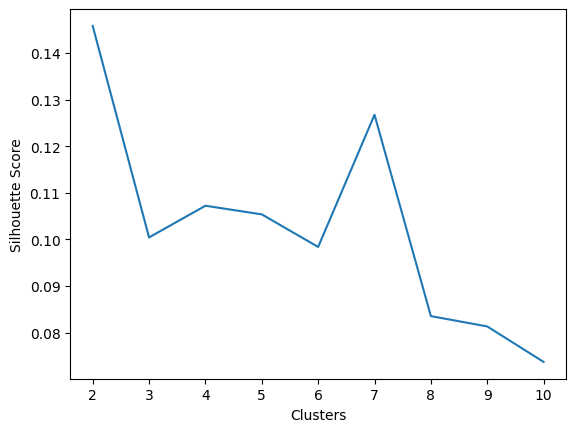

In [62]:
# Select number of clusters using "elbow" heuristic
# Evaluate using sklearn's shillouette score metric / higher is better

# NOTE: Will research more methods of cluster detection

score = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
    kmeans.fit(X)
    score.append(silhouette_score(X, kmeans.labels_))

plt.plot(range(2, 11), score)
plt.xlabel("Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, 11))
plt.show()

In [63]:
kmeans = KMeans(n_clusters=7, n_init="auto", random_state=42)
kmeans.fit(X)
score.append(silhouette_score(X, kmeans.labels_))

In [64]:
# Produce mapping
# Source: https://gist.github.com/radcliff/f09c0f88344a7fcef373

mapping_name_to_iso = (
    pd.read_csv("../misc/wikipedia-iso-country-codes.csv")
    .set_index("Alpha-3 code")
    .to_dict()["Numeric code"]
)

iso_codes = [mapping_name_to_iso[c] for c in df['Country'].unique()]

In [65]:
# Plot clusters on a world map for visualization purposes
world_data = alt.topo_feature(data.world_110m.url, "countries")
ocean = alt.Chart(alt.sphere()).mark_geoshape(fill="lightblue")

countries = (
    alt.Chart(world_data)
    .mark_geoshape(stroke="black", strokeWidth=0.15)
    .encode(
        color=alt.Color(
            "Cluster:N",
        )
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(
            pd.DataFrame({"ISO": iso_codes, "Cluster": kmeans.labels_}),
            "ISO",
            ["Cluster"],
        ),
    )
)

world_map = (
    (ocean + countries)
    .project("naturalEarth1")
    .properties(
        width=1000,
        height=500,
        title="Clustering of OECD countries for 2015, using World Bank Gender Indicators",
    )
)

world_map

alt.LayerChart(...)

## Investigation of Clusters